In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [9]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [10]:
train['date_time'] = pd.to_datetime(train['date_time'])
test['date_time'] = pd.to_datetime(test['date_time'])

In [13]:
train['year'] = train['date_time'].dt.year
train['month'] = train['date_time'].dt.month
train['day'] = train['date_time'].dt.day_of_year - 90
train['week'] = train['date_time'].dt.week
train['weekday'] = train['date_time'].dt.weekday

In [14]:
test['year'] = test['date_time'].dt.year
test['month'] = test['date_time'].dt.month
test['day'] = test['date_time'].dt.day_of_year - 90
test['week'] = test['date_time'].dt.week
test['weekday'] = test['date_time'].dt.weekday

In [29]:
X = train.drop(['date_time', 'number_of_rentals'], axis = 1)
y = train.number_of_rentals

In [115]:
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from itertools import combinations
from sklearn.metrics import make_scorer

In [41]:
kf = KFold(n_splits = 10, random_state = 42, shuffle = True)

In [116]:
xgb = XGBRegressor(random_state = 42, learning_rate = 0.1, max_depth = 4)

In [117]:
%%time
nmae_list = []
features = []
for n in range(5, X.shape[1] + 1) :
    combs = list(combinations(X.columns, n))
    
    for comb in combs :
        feature = list(comb)
        features.append(feature)
        samp = X[feature]
        xgb_cv = cross_val_score(xgb, samp, y, cv = kf, scoring = 'neg_mean_absolute_error')
        nmae = xgb_cv.mean()
        nmae_list.append(nmae)

CPU times: user 4h 52min 34s, sys: 48min 11s, total: 5h 40min 45s
Wall time: 45min 33s


In [118]:
result = pd.DataFrame({'features' : features, 'NMAE' : nmae_list})

In [125]:
f = result.sort_values(by = 'NMAE').tail(1).features.values[0]

In [141]:
xgb = XGBRegressor(random_state = 42)

In [143]:
xgb.fit(X[f], y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.12, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [144]:
pred = xgb.predict(test[f])

In [107]:
submission = pd.read_csv('sample_submission.csv')

In [145]:
submission['number_of_rentals'] = pred

In [148]:
best = pd.read_csv('20211105_2nd.csv')

In [111]:
import matplotlib.pyplot as plt
%matplotlib inline

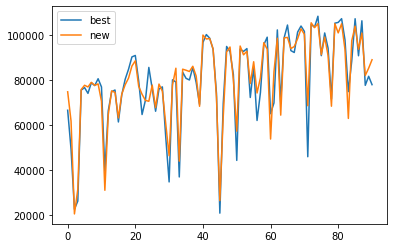

In [150]:
plt.plot(best['number_of_rentals'], label = 'best')
plt.plot(pred, label = 'new')
plt.legend()
plt.show()

In [151]:
submission.to_csv('20211105_3rd.csv', index = False)